In [1]:
import os 
import codecs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, PCA, TruncatedSVD, SparsePCA, LatentDirichletAllocation
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import sentencepiece as spm
import optuna

In [2]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
SEED = 42
seed_everything(SEED)

In [3]:
train_df = pd.read_csv("./input/train_data.csv")
test_df = pd.read_csv("./input/test_data.csv")

train_length = len(train_df)
test_length = len(test_df)

# number of spam and ham -------------------------------------------------------
n_train_not_spam = 8707
n_train_spam = 171
n_test_not_spam = 7838
n_test_spam = 17000

test_not_spam_ration = n_test_not_spam/n_test_spam  # 7838 / 17000
test_spam_ration = n_test_spam / n_test_not_spam  # 17000 / 7838

In [4]:
class Preprocessor:
    def __init__(self):
        pass
    def __remove_head(self, X):
        """先頭のSubject:を削除"""
        X_series = pd.Series(X)
        if X_series.str.startswith("Subject:").all():
            X_series = X_series.apply(lambda c: c[9:])
        X = X_series.values
        return X
    
    def preprocess(self, X):
        X = X.copy()
        X = self.__remove_head(X)
        return X

In [5]:
class SentencePieceTokenizer:
    def __init__(self, model_prefix, vocab_size=5000, 
                user_defined_symbols = ("(",")","\"","-",".","–","£","€"),
                shuffle_input_sentence = True, character_coverage=1.0,
                model_type="unigram"):
        self.processor = spm.SentencePieceProcessor()
        self.model_prefix = model_prefix
        self.vocab_size = vocab_size
        self.user_defined_symbols = user_defined_symbols
        self.shuffle_input_sentence = shuffle_input_sentence
        self.character_coverage = character_coverage
        self.model_type = model_type
    def __call__(self, raw_document):
        return self.tokenize(raw_document)
    
    def tokenize(self, raw_document):
        return self.processor.EncodeAsPieces(raw_document)
    
    def fit(self, X):
        document_file = f"{self.model_prefix}.txt"
        # すべての文字列をテキストファイルに書き出す
        print(*X, sep="\n", file=codecs.open(document_file, "w", "utf-8"))
        spm.SentencePieceTrainer.Train(
            input = document_file,
            model_prefix = self.model_prefix,
            vocab_size = self.vocab_size,
            user_defined_symbols = self.user_defined_symbols,
            shuffle_input_sentence = self.shuffle_input_sentence,
            character_coverage = self.character_coverage,
            model_type = self.model_type
        )
        model_name = f"{self.model_prefix}.model"
        self.processor.Load(model_name)

In [6]:
is_not_spam = train_df["y"] == 0
is_spam = train_df["y"] == 1

is_not_spam_index = np.where(is_not_spam)[0]
is_spam_index = np.where(is_spam)[0]

In [7]:
X = pd.DataFrame(train_df["contents"])
y = pd.DataFrame(train_df["y"])

In [8]:
#Class Dictionary
tokenizer_cls_dict = {
    "SentencePieceTokenizer":SentencePieceTokenizer
}

vectorizer_cls_dict = {
    "CountVectorizer": CountVectorizer,
    "TfidfVectorizer": TfidfVectorizer
}

decomposition_cls_dict = {
    "NMF":NMF, "PCA":PCA, "SparsePCA":SparsePCA, 
    "TruncatedSVD":TruncatedSVD,
    "LatentDirichletAllocation":LatentDirichletAllocation
}

model_cls_dict = {
    "MultinomialNB":MultinomialNB,
    "LGBMClassifier":LGBMClassifier
}

In [9]:
n_splits = 20
tokenizer_name = "SentencePieceTokenizer"
tokenizer_params = {
    "model_prefix": "train",
    "vocab_size": 2247,  # 5000,
    "user_defined_symbols": ["(",")","\"","-",".","–","£","€"],
    "shuffle_input_sentence": True,
    "character_coverage": 1.0,
    "model_type": "unigram"}

vectorizer_name = "CountVectorizer"
vectorizer_params = {
    "min_df": 0.0019210379695393533,  # 2
    "max_df": 0.1501408652009228,  # 0.7
    "ngram_range": (1, 2),  # (1, 1),
    "stop_words": None,
    "token_pattern": None}

model_name = "MultinomialNB"
model_params = {}
model_fit_params = {}

In [10]:
val_preds = np.zeros(train_length)
preds = []
preprocessor = Preprocessor()
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

for (train_index_spam, val_index_spam), (train_index_not_spam, val_index_not_spam) in zip(kfold.split(is_spam_index), kfold.split(is_not_spam_index)):
    # print(train_index_spam.shape, val_index_spam.shape, train_index_not_spam.shape, val_index_not_spam.shape)
    # print(train_index_spam, val_index_spam, train_index_not_spam, val_index_not_spam)

    # downsampling ---------------------------------------------------------------
    n_train_spam = len(train_index_spam)
    train_index_not_spam = np.random.choice(train_index_not_spam, n_train_spam, replace=False)
    n_val_spam = len(val_index_spam)
    val_index_not_spam_downsampled = np.random.choice(val_index_not_spam, n_val_spam, replace=False)

    train_index = np.concatenate((is_spam_index[train_index_spam], is_not_spam_index[train_index_not_spam]), axis=0)
    val_index = np.concatenate((is_spam_index[val_index_spam], is_not_spam_index[val_index_not_spam]), axis=0)
    val_index_downsampled = np.concatenate((is_spam_index[val_index_spam], is_not_spam_index[val_index_not_spam_downsampled]), axis=0)

    X_resampled = X.loc[train_index, "contents"].values
    y_resampled = y.loc[train_index, "y"].values
    X_val = X.loc[val_index, "contents"].values
    y_val = y.loc[val_index, "y"].values
    X_val_downsampled = X.loc[val_index_downsampled, "contents"].values
    y_val_downsampled = y.loc[val_index_downsampled, "y"].values

    # preprocess -----------------------------------------------------------------
    X_resampled = preprocessor.preprocess(X_resampled)
    X_val = preprocessor.preprocess(X_val)
    X_val_downsampled = preprocessor.preprocess(X_val_downsampled)

    # tokenizer ------------------------------------------------------------------
    tokenizer = tokenizer_cls_dict[tokenizer_name](**tokenizer_params)
    tokenizer.fit(X_resampled)

    # vectorizer -----------------------------------------------------------------
    vectorizer = vectorizer_cls_dict[vectorizer_name](tokenizer=tokenizer, **vectorizer_params)
    vectorizer.fit(X_resampled)

    # 単語の出現回数取得 ---------------------------------------------------------
    # 単語の種類の表示
    print('word size: ', len(vectorizer.vocabulary_))
    # 先頭５件の単語を表示
    print('word content: ', dict(list(vectorizer.vocabulary_.items())[0:5]))

    # 訓練データと検証データをベクトル化 -----------------------------------------
    X_resampled_vec = vectorizer.transform(X_resampled)
    X_val_vec = vectorizer.transform(X_val)
    X_val_vec_downsampled = vectorizer.transform(X_val_downsampled)

    # 学習 -----------------------------------------------------------------------
    model = model_cls_dict[model_name](**model_params)
    model.fit(X_resampled_vec, y_resampled, **model_fit_params)

    # validation data の予測 -----------------------------------------------------
    val_pred = model.predict_proba(X_val_vec)[:, 1]
    val_preds[val_index] = val_pred
    val_pred_downsampled = model.predict_proba(X_val_vec_downsampled)[:, 1]

    # F1スコアのprint
    print("val_F1-score",f1_score(y_val, np.where(val_pred>0.5, 1, 0)))
    print("downsampled_val_F1-score",f1_score(y_val_downsampled, np.where(val_pred_downsampled>0.5, 1, 0)))
    print("------------------------------------------------------------------------------------------------------------------")

    # testデータをベクトル化
    # df_data = pd.DataFrame(test, columns=['contents'])
    input_vec = vectorizer.transform(preprocessor.preprocess(test_df['contents'].values))

    # testの予測→seed毎に空のリストに格納
    pred = model.predict_proba(input_vec)
    preds.append(pred)
    # end for ----------------------------------------------------------------------

    # Classification Report --------------------------------------------------------
    print()
    print(classification_report(y["y"].values, np.where(val_preds>0.5, 1, 0), digits=4, target_names=["not_spam", "spam"]))
    print("oof_F1-score",f1_score(y["y"].values, np.where(val_preds>0.5, 1, 0)))
    print()

    # resampled classification report
    n_sample_not_spam_index = int(len(is_spam_index) * test_not_spam_ration)
    sample_not_spam_index = np.random.choice(is_not_spam_index, n_sample_not_spam_index, replace=False)
    sample_index = np.concatenate((sample_not_spam_index, is_spam_index))
    print("resampled:")
    print(classification_report(y.loc[sample_index, "y"].values, np.where(val_preds[sample_index]>0.5, 1, 0), digits=4, target_names=["not_spam", "spam"]))
    print("resampled oof_F1-score",f1_score(y.loc[sample_index, "y"].values, np.where(val_preds[sample_index]>0.5, 1, 0)))
    print()

    # Average resampled F1 score ---------------------------------------------------
    sample_scores = []
    n_sample_scores = 20  # Nunmber of downsampled F1 scores
for i in range(n_sample_scores):
    n_sample_not_spam_index = int(len(is_spam_index) * test_not_spam_ration)
    sample_not_spam_index = np.random.choice(is_not_spam_index, n_sample_not_spam_index, replace=False)
    sample_index = np.concatenate((sample_not_spam_index, is_spam_index))
    # print("resampled:")
    # print(classification_report(y.loc[sample_index, "y"].values, np.where(val_preds[sample_index]>0.5, 1, 0), digits=4, target_names=["not_spam", "spam"]))
    sample_score = f1_score(y.loc[sample_index, "y"].values, np.where(val_preds[sample_index]>0.5, 1, 0))
    # print("resampled oof_F1-score",sample_score)
    sample_scores.append(sample_score)
print("sample f1 scores:", sample_scores)
print("mean sample f1 score:", np.mean(sample_scores))

# To Numpy Array ---------------------------------------------------------------
preds = np.array(preds)
preds = preds[:, :, 1]

preds_mean = preds.mean(axis=0)  # The mean of the prediction for the test data for each CV

word size:  44114
word content:  {'ke': 12705, 'to': 19660, 'ck': 6783, '▁success': 40167, '▁structure': 40100}
val_F1-score 0.6428571428571429
downsampled_val_F1-score 0.9473684210526316
------------------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    not_spam     0.9817    0.9989    0.9902      8707
        spam     0.4737    0.0526    0.0947       171

    accuracy                         0.9806      8878
   macro avg     0.7277    0.5257    0.5425      8878
weighted avg     0.9719    0.9806    0.9730      8878

oof_F1-score 0.09473684210526316

resampled:
              precision    recall  f1-score   support

    not_spam     0.3250    1.0000    0.4906        78
        spam     1.0000    0.0526    0.1000       171

    accuracy                         0.3494       249
   macro avg     0.6625    0.5263    0.2953       249
weighted avg     0.7886    0.3494    0.2223       24

In [11]:
threshold = 0.5
is_spam_index_ = y["y"] == 1
print(sum(y.loc[is_spam_index_, "y"].values == np.where(val_preds[is_spam_index_]>threshold, 1, 0)) / len(y[is_spam_index_]))

0.9766081871345029


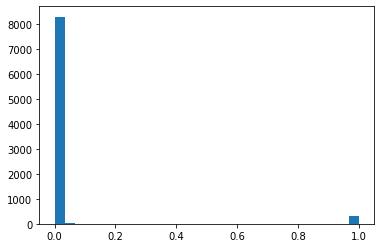

In [12]:

plt.hist(val_preds[~is_spam_index_], bins=30)
plt.show()

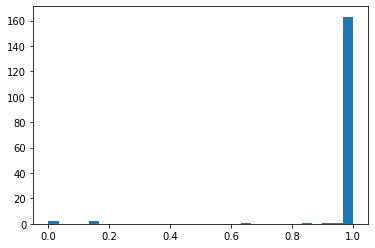

In [13]:
plt.hist(val_preds[is_spam_index_], bins=30)
plt.show()